![image-3.png](https://github.com/cafawo/Derivatives/blob/main/figures/fscampus_small.png?raw=1)

# Derivatives

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
Frankfurt School of Finance & Management

fabian.woebbeking@dozent.frankfurt-school.de

## Case 5: Options

### Part 1: Intro

#### Task: Explain how the six main factors influence the value of an option.

| **    Variable   **   | **    European Call   ** | **    European Put   ** | **    American Call   ** | **    American Put   ** |
|-----------------------|:------------------------:|:-----------------------:|:------------------------:|:-----------------------:|
|     current price     |             +            |             -           |             +            |             -           |
|     strike            |             -            |             +           |             -            |             +           |
|     Maturity          |             ?            |             ?           |             +            |             +           |
|     volatility        |             +            |             +           |             +            |             +           |
|     risk free rate    |             +            |             -           |             +            |             -           |
|     Dividends         |             -            |             +           |             -            |             +           |
|        Dividends      |             -            |             +           |             -            |             +           |

#### Task: Calculate the minimum value of a call with a strike of 25 and 4 months to maturity. The underlying has a spot price of 28 and the continuous rate is 8%.

In [8]:
import numpy as np

minimum_value = 28 - 25 * np.exp(-0.08 * 4 / 12)

print(f"Minimum value = EUR {minimum_value:,.2f}")

Minimum value = EUR 3.66


#### Task: Explain why it is not rational to early exercise an American call on a share with no dividends.

Loss of time-value, i.e.

$
S_T < \max(S_T, K)
$

#### Task: Why does the put call parity not work for American options?

No arbitrage relationship as

$
C + K e^{(-rT)} < P + S
$

### Part 2: Stochastic processes

#### Task: The liquidity position of a firm measured in million is a generalized Wiener process with a drift of $0.1$ per month and a variance of $\sigma^2 = 0.16$ per month. The initial cash position is $2.0$. Calculate:

1. 	the expected value and standard deviation in one, six and 12 months.

2.	What is the probability of a negative cash position in 6 and 12 months? 

Probability of illiquidity in  6 month: 0.3982%
Probability of illiquidity in 12 month: 1.0461%
Probability of illiquidity in 36 month: 0.9815%


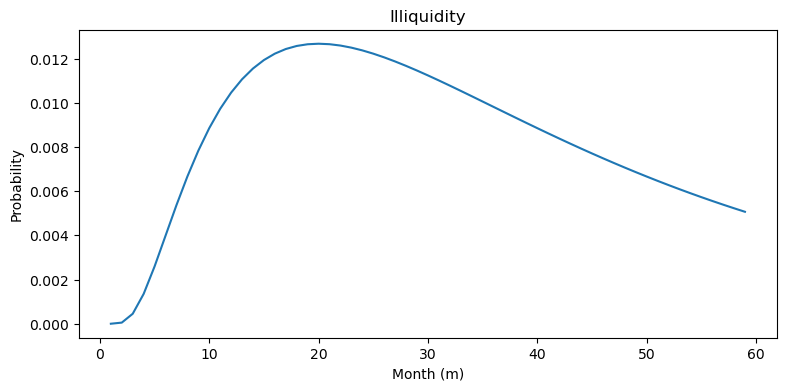

In [9]:
"""Calculate the probability of illiquidity
"""
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def prob_illiquid(m, const=2, drift=.1, variance=.16):
    expected_cash = const + drift * m
    sigma = (variance * m)**0.5
    p_illiquid = norm.cdf( (0 - expected_cash) / sigma ,0,1)  # normalization: (x - mu) / sigma
    return p_illiquid

print(f"Probability of illiquidity in  6 month: {prob_illiquid(6)*100:.4f}%")
print(f"Probability of illiquidity in 12 month: {prob_illiquid(12)*100:.4f}%")
print(f"Probability of illiquidity in 36 month: {prob_illiquid(36)*100:.4f}%")


X = range(1,12*5, 1)
fX = list(map(lambda m: prob_illiquid(m), X))

plt.figure('Illiquidity', figsize=(9,4))
plt.title("Illiquidity")
plt.plot(X, fX)
plt.xlabel("Month (m)")
plt.ylabel("Probability")
plt.show()

#### Task: A share has an expected return of 16% p.a. with a volatility of 30% (365 days). The spot price of the share is 50. Calculate:

1. tomorrow’s expected share price,

2. it’s standard deviation,

3. a 95% confidence interval 

4. the value at risk for one day at a 95% level. 

5. Simulate the movement of the share for 15 trading days.


In [10]:
from scipy.stats import norm

S_0 = 50
mu = 0.16
sigma = 0.3

# Expected price and price volatility
S_1 = 50 * (1 + mu / 365)
print(f"E[S] tomorrow = {S_1:.4f}")
price_vola = 50 * sigma * (1 / 365)**0.5
print(f"Price vola    =  {price_vola:.4f}")

# Confidence interval
q975 = norm.ppf(0.975, 0, 1)
print(f"With 95% confidence: {S_1 - price_vola * q975 :.2f} < S_1 < {S_1 + price_vola * q975 :.2f}")

# Value at risk
q95 = norm.ppf(0.95, 0, 1)
print(f"1 day 95% VaR =  {S_0 * (sigma * (1 / 365)**0.5 * q95 - mu / 365) :.2f}")

E[S] tomorrow = 50.0219
Price vola    =  0.7851
With 95% confidence: 48.48 < S_1 < 51.56
1 day 95% VaR =  1.27


### Part 3: Cox-Ross-Rubinstein

#### Task: Evaluate the following one year options using the Cox-Ross-Rubinstein model.

Evaluate the following one year options on a share with a spot price of 220. The Volatility is 98% and the interest rate is 21% p.a. ISMA. Use a two step lattice.

1. European call with strike 165
2. American call with strike 165
3. European put  with strike 220
4. American put  with strike 220

In [11]:
"""Full CRR model
"""
import numpy as np

def Binomial(n, S, K, r, v, t, PutCall=1, American=False):  
    At = t/n 
    u = np.exp(v*np.sqrt(At))
    d = 1./u
    p = (np.exp(r*At)-d) / (u-d) 
    # Binomial price tree
    stockvalue = np.zeros((n+1,n+1))
    stockvalue[0,0] = S
    for i in range(1,n+1):
        stockvalue[i,0] = stockvalue[i-1,0]*u
        for j in range(1,i+1):
            stockvalue[i,j] = stockvalue[i-1,j-1]*d
    # option value at final node    
    optionvalue = np.zeros((n+1,n+1))
    for j in range(n+1):
        optionvalue[n,j] = max(0, PutCall*(stockvalue[n,j]-K))
    # recursive calculations   
    for i in range(n-1,-1,-1):
        for j in range(i+1):
            if American:
                optionvalue[i,j] = max(0, PutCall*(stockvalue[i,j]-K), np.exp(-r*At)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1]))
            else:
                optionvalue[i,j] = np.exp(-r*At)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1])
    return optionvalue[0,0]

# Inputs
S_0   = 220  # price of the underlying
sigma = .98  # volatility
rate  = np.log(1 + 0.21)  # converting the ISDA rate
T     = 1    # time to maturity
steps = 2    # steps

#Graphs and results for the Option prices
print(f"European Call Price: {Binomial(steps, S_0, 165, rate, sigma, T, PutCall=1):,.2f}")
print(f"American Call Price: {Binomial(steps, S_0, 165, rate, sigma, T, PutCall=1, American=True):,.2f}")
print(f"European Put  Price:  {Binomial(steps, S_0, 220, rate, sigma, T, PutCall=-1):,.2f}")
print(f"American Put  Price:  {Binomial(steps, S_0, 220, rate, sigma, T, PutCall=-1, American=True):,.2f}")

European Call Price: 116.35
American Call Price: 116.35
European Put  Price:  49.07
American Put  Price:  59.98


#### Task: Evaluate the following binary options, using the Cox-Ross-Rubinstein model with parameters from above.

1. European cash or nothing option with Strike 165 and a payout of 165.
2. European asset or nothing option with a strike 165.

In [12]:
from scipy.stats import binom

# Recall our CRR parameters
sigma = .98  # volatility
rate  = np.log(1 + 0.21)  # converting the ISDA rate
T     = 1    # time to maturity
steps = 2    # steps
dt = T / steps 
u = np.exp(sigma*np.sqrt(dt))
d = 1 / u
p = (np.exp(rate*dt)-d) / (u-d)


binomial_tree = []
for n in range(steps+1):
    binomial_tree.append([])
    for k in range(n+1):
        S_nk = S_0 * u**(k) * d**(n-k)
        binomial_tree[-1].append(S_nk)

CoN_payout = []
AoN_payout = []
for n, S in enumerate(binomial_tree[-1]):  # This is the binomial tree that we generated above
    if S > 165:  # strike
        AoN_payout.append( binom.pmf(n, steps, p) * S * np.exp(-rate*T) )
        CoN_payout.append( binom.pmf(n, steps, p) * 165 * np.exp(-rate*T) )
AoN = sum(AoN_payout)
CoN = sum(CoN_payout)

print(f"Price asset or nothing = {AoN:.4f}")
print(f"Price cash or nothing  =  {CoN:.4f}")
print(f"AoN - CoN              = {AoN - CoN:.4f}")
print(f"CRR call price (above) = {Binomial(steps, S_0, 165, rate, sigma, T, PutCall=1):.4f}")

Price asset or nothing = 203.6337
Price cash or nothing  =  87.2827
AoN - CoN              = 116.3510
CRR call price (above) = 116.3510


#### Task: Explain the relationship between plain vanilla and binary options.

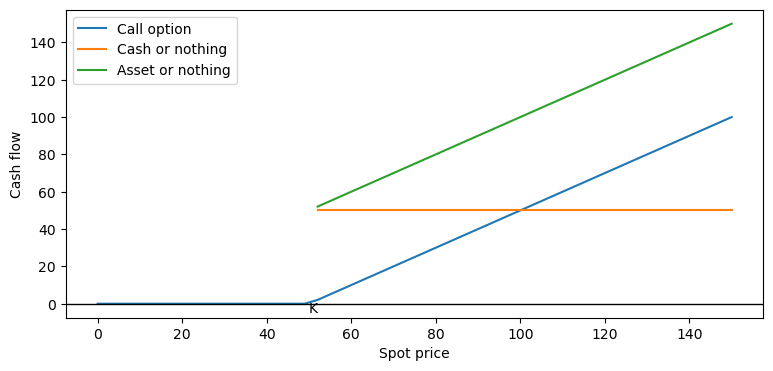

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# see workbook task 4 ff.
S_T = np.linspace(0,150)
K = 50

# portfolio
CF_CoN = K * (S_T > K)
CF_AoN = S_T * (S_T > K)
CF_T = CF_AoN - CF_CoN

# hacky removal of 0 (looks better in plot)
CF_CoN = np.array(CF_CoN, dtype=np.double)
CF_CoN[CF_CoN==0] = np.nan
CF_AoN = np.array(CF_AoN, dtype=np.double)
CF_AoN[CF_AoN==0] = np.nan

# the rest is plotting
plt.figure('PCP', figsize=(9,4))
plt.plot(S_T, CF_T, label="Call option")
plt.plot(S_T, CF_CoN, label="Cash or nothing")
plt.plot(S_T, CF_AoN, label="Asset or nothing")
plt.axhline(y=0, linewidth=1, color="black")
plt.xlabel("Spot price")
plt.ylabel("Cash flow")
plt.annotate("K", (K,-5))
plt.legend(loc="upper left")
plt.show()

### Part 4: Black-Scholes-Merton

#### Task: Price an option using the Merton model.

The spot price of a share is EUR 300 with a dividend yield of 3% and an interest rate of 8% (ISMA). Evaluate a half year call with a strike 300 and a volatility of 20% using the Merton model.

In [14]:
import numpy as np
from scipy.stats import norm

#%% Black-Scholes formula
def merton(cpflag,S,K,T,r,sigma, q=0):
    # cpflag in {1 for call, -1 for put}
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    price = cpflag * (S * np.exp(-q*T) * norm.cdf(cpflag*d1, 0.0, 1.0) - K * np.exp(-r * T) * 
            norm.cdf(cpflag*d2, 0.0, 1.0))
    return price

print(f"European Call Price (incl dividends): EUR {merton(1,300,300,0.5,np.log(1.08),0.2,np.log(1.03)):,.4f}")

European Call Price (incl dividends): EUR 20.1605
